In [ ]:
"""Stratagy :  [ RSI_14>EMA_15 CROSSED RSI_14 ON 1MIN ]

Stage 1 : identyfy on candels
stage 2 : genarate Signal
Stage 3 : Create Signal Table with SL & TP
Stage 4 : plot it
Stage 5 : Back test

Stage 6: improve..

"""

In [ ]:
""" IMPORTING all"""

import mplfinance as mpf
import numpy as np
import pandas as pd

from resampler import EnterpriseDataResampler
from tafm import create_analyzer, IndicatorConfig
from ChartterX5 import Chartter

In [ ]:
""" data loading and improting numbpy pandas

"""
ohlc = pd.read_parquet("./src/DAT_ASCII_XAUUSD_M1_2024.parquet")

In [ ]:
resampler = EnterpriseDataResampler()

dta = resampler.resample_data(
        resampler.filter_business_data(
            resampler.date_filter.filter_by_date_range(
                ohlc,
                start_date="2024-10-01",
                end_date="2024-10-02"
            ),
            business_hours_only=False,
            weekdays_only=True
        ),
        period="1T"
    ).set_index("datetime")

In [ ]:
"""Applying tecNical Ananlisis.."""
dta = dta.rename(columns={
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "volumen": "Volume"  # fix spelling too
})

analyzer = create_analyzer(dta)

analyzer.add_indicator(IndicatorConfig(name='RSI', period=14, source_column='Close'))
analyzer.add_indicator(IndicatorConfig(name='EMA', period=15, source_column='RSI_14'))


In [ ]:
#>=Signal Genarator

analyzer.crossed_up('RSI_14', 'EMA_15')

analyzer.df.tail(3)

In [ ]:
ohlcv = analyzer.df.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"  # fix spelling too
})


In [ ]:
import pandas as pd

# --- Define Forex sessions in UTC ---
sessions = {
    "Tokyo": ("00:00", "09:00"),
    "London": ("08:00", "17:00"),
    "New_York": ("13:00", "22:00"),
    "Sydney": ("22:00", "07:00")
}

# --- Function to filter a session ---
def get_session(df, start_time, end_time):
    times = df.index.time
    start = pd.to_datetime(start_time).time()
    end = pd.to_datetime(end_time).time()

    if start < end:
        return df.between_time(start_time, end_time)
    else:
        return df[(times >= start) | (times <= end)]

# --- Split OHLCV into sessions ---
session_dfs = {name: get_session(ohlcv, start, end) for name, (start, end) in sessions.items()}

# --- Extract signal times (RSI_14_above_EMA_15 == 1) ---
signal_times = ohlcv.index[ohlcv['RSI_14_crossed_up_EMA_15'] == 1]

# --- Access individual sessions ---
tokyo    = session_dfs["Tokyo"]
london   = session_dfs["London"]
new_york = session_dfs["New_York"]
sydney   = session_dfs["Sydney"]

# Optional: inspect
for name, df in session_dfs.items():
    print(f"{name} session: {len(df)} rows, signals: {df['RSI_14_crossed_up_EMA_15'].sum()}")

# --- Now signal_times can be passed to Chartter/ mplfinance vlines ---
# Example:
# chartter.plot(ohlcv, vlines={"tlines": signal_times.to_list(), "colors":"white", "linewidths":0.7, "linestyle":"--"})

tokyo


In [ ]:
# Filter rows where condition is true
signal_times = tokyo.index[tokyo['RSI_14_crossed_up_EMA_15'] == 1].to_list()


In [ ]:
# Initialize chartter with wider and less tall proportions, no volume
chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'figratio': (20, 8),  # Adjusted for wider and less tall chart
    'volume': False  # Disable volume bars
})

# --- TradingView Market Colors ---
tv_mc = mpf.make_marketcolors(
    up='#26a69a',         # TradingView teal green for up candles
    down='#ef5350',       # TradingView red for down candles
    edge='inherit',       # Clean edges matching candle color
    wick='inherit',       # Wicks match candle colors
)

# --- TradingView Dark Theme ---
tradingview_dark = mpf.make_mpf_style(
    base_mpf_style='nightclouds',  # Start with dark base
    marketcolors=tv_mc,

    # TradingView dark theme colors
    figcolor='#131722',           # Dark navy background
    facecolor='#1e222d',          # Dark gray chart area
    gridcolor='#363a45',          # Dark gray grid
    gridstyle='-',                # Solid grid lines

    y_on_right=True,              # Price axis on right

    rc={
        # TradingView typography
        # 'font.family': ['-apple-system', 'BlinkMacSystemFont', 'Trebuchet MS', 'Roboto', 'Ubuntu', 'sans-serif'],
        'axes.labelsize': 10,
        'axes.titlesize': 14,
        'xtick.labelsize': 9,
        'ytick.labelsize': 7,         # Reduced size for price tick labels
        'legend.fontsize': 9,

        # Clean spacing with reduced left padding and full-width chart
        'axes.labelpad': 10,
        'xtick.major.pad': 6,
        'ytick.major.pad': 6,
        'axes.xmargin': 0,            # Remove left/right margins
        'axes.ymargin': 0,            # Remove top/bottom margins
        'figure.subplot.left': 0.05,  # Minimize left subplot padding
        'figure.subplot.right': 0.95, # Maximize right subplot to fit price scale

        # TradingView-style lines
        'lines.linewidth': 1.5,
        'lines.antialiased': True,

        # Clean borders and colors
        'axes.edgecolor': '#434651',  # Darker edge for dark theme
        'axes.linewidth': 1,
        'xtick.color': '#787b86',     # Light gray for x-axis ticks
        'ytick.color': '#787b86',     # Light gray for y-axis ticks
        'axes.labelcolor': 'none',    # Hide axis label color (labels are empty)

        # Grid styling
        'axes.grid': True,
        'axes.axisbelow': True,
        'grid.alpha': 0.6,            # Slightly more transparent for dark theme
        'grid.linewidth': 0.8,

        # Clean spines (show right spine for price scale)
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.top': False,
        'axes.spines.right': True,    # Show right spine for price scale
        'ytick.right': True,          # Show right y-axis ticks
    }
)


2025-09-25 15:45:02,153 - INFO - Generating chart ccd61d07-e831-45d6-8ed8-6dfa1ba35504 with 542 data points


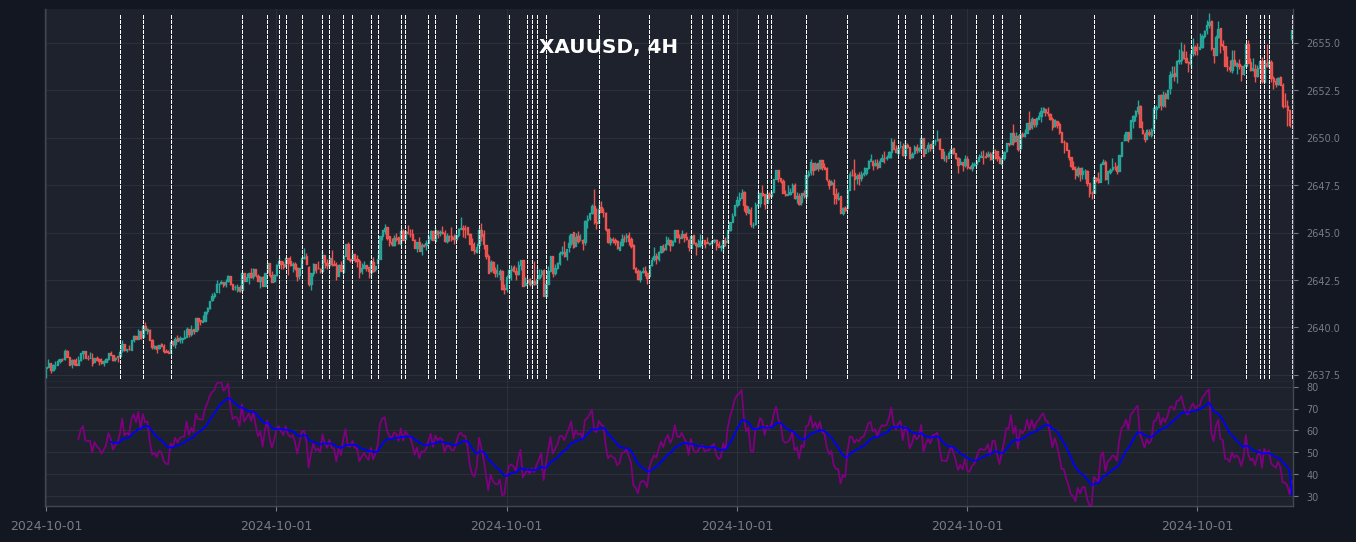

2025-09-25 15:45:06,176 - INFO - Chart ccd61d07-e831-45d6-8ed8-6dfa1ba35504 generated successfully in 4.04s


In [46]:
# --- TradingView Configuration ---
tradingview_config_4H = {
    'title': 'XAUUSD, 4H',                # TradingView style title
    'style': tradingview_dark,             # Use dark theme
    'type': 'candle',
    'volume': False,                      # Disable volume bars
    'show_nontrading': False,             # Ensure no extra y-axis spacing
    'datetime_format': '%Y-%m-%d',        # Format x-axis to show date only
    'xlabel': '',                         # Remove x-axis label
    'ylabel': '',                         # Remove y-axis label
    'xrotation': 0                        # Horizontal date labels
}

chartter.plot(
    tokyo,
    addplot = [
        mpf.make_addplot(tokyo['RSI_14'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot(tokyo['EMA_15'], panel=1, color='blue', ylabel='ema15'),
    ],
    config=tradingview_config_4H,
    vlines=dict(
        vlines=signal_times,
        colors='white',
        linewidths=0.7,
        linestyle="--"
    )
)